In [ ]:
import numpy as np
import pandas as pd
from numpy import array

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import array
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive')

In [ ]:
def buildLaggedFeatures(s,lag=2,dropna=True):
    #Builds a new DataFrame to facilitate regressing over all possible lagged features'''
    if type(s) is pd.DataFrame:
        new_dict={}
        for l in range(lag,0,-1):
            #new_dict[col_name]=s[col_name]
            # create lagged Series
            for col_name in s:
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        for col_name in s:
            new_dict[col_name]=s[col_name]
        res=pd.DataFrame(new_dict,index=s.index)
        #print(res.head())

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 

In [ ]:
def create_data(data,lag):
    #o_data = read_csv('NLIC_stock.csv', header=0)
    #data['Date'] = pd.to_datetime(o_data['Date'])
    #mask = (data['Date'] > '2011-11-11') & (data['Date'] <= '2018-12-30')
    #t_data=data.loc[mask]
    t_data= data.drop(columns=['Symbol'])
    t_data.set_index(['Date'], inplace=True)
    t_data=t_data.drop(columns=['Open','High','Vol','Low'])
    res=buildLaggedFeatures(t_data,lag,dropna=True)
    res=res.drop(columns=['Close'])
    #print(res.head())
    return res  

In [ ]:
def create_yvalues(df,lead):
    dataY = []
    #print(df.head())
    for i in range(len(df)-lead):
        dataY.append(df[i:(i+lead)])
    return np.array(dataY)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/NLIC_stock.csv', header=0)
data['Date'] = pd.to_datetime(data['Date'])
mask = (data['Date'] > '2011-11-11') & (data['Date'] <= '2018-12-31')
t_data=data.loc[mask]
lag=12
prediction_days=6
trainX= create_data(t_data,lag)
tY= data[lag:len(trainX)+prediction_days+lag]
#print(len(trainX),len(trainY))
trainY=create_yvalues(tY['Close'],prediction_days)
trainY=pd.DataFrame(trainY)
print(trainX.head())


print(trainY.head())

#print(trainX.head(),trainY.head(5))
#print(trainX.shape)



            Close_lag12  Close_lag11  ...  Close_lag2  Close_lag1
Date                                  ...                        
2012-02-05        558.0        569.0  ...       631.0       631.0
2012-02-06        569.0        615.0  ...       631.0       635.0
2012-02-07        615.0        627.0  ...       635.0       647.0
2012-02-08        627.0        627.0  ...       647.0       640.0
2012-02-14        627.0        625.0  ...       640.0       640.0

[5 rows x 12 columns]
     0    1    2    3    4    5
0  635  647  640  640  640  645
1  647  640  640  640  645  641
2  640  640  640  645  641  642
3  640  640  645  641  642  654
4  640  645  641  642  654  650


In [ ]:
P=create_data(data,lag)
scaler1=MinMaxScaler()
p=scaler1.fit_transform(P.values)
train_x = scaler1.transform(trainX.values)
# split into train and test sets
scaler2=MinMaxScaler()
#print(Q.tail())
#q=scaler2.fit_transform(Q.values)

#print(c)
train_y=scaler2.fit_transform(trainY.values)
train_x=np.array(train_x)
train_y=np.array(train_y)
c=scaler2.inverse_transform(train_y)
#print(c[1512-12:])
#print(train_y[1512-12:])

train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
train_y =np.reshape(train_y, (train_y.shape[0], train_y.shape[1], 1))
print(len(train_x),len(train_y),train_x.shape,train_y.shape)

1505 1505 (1505, 12, 1) (1505, 6, 1)


In [ ]:
from keras.optimizers import Adam
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
batch_size = 32
opt=Adam(
    learning_rate=0.0015,
    beta_1=0.9,
    beta_2=0.99,
    epsilon=1e-05,
    amsgrad=True,
    )
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(lag,1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(prediction_days))
model.add(LSTM(200, activation='tanh', return_sequences=True))
#model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer=opt)


In [ ]:
%%time
history=model.fit(train_x, train_y, epochs=150, batch_size=batch_size, shuffle=False)

Epoch 1/150
48/48 [==============================] - 2s 5ms/step - loss: 0.0224
Epoch 2/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0469
Epoch 3/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0414
Epoch 4/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 5/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0660
Epoch 6/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0562
Epoch 7/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0399
Epoch 8/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0172
Epoch 9/150
48/48 [==============================] - 0s 5ms/step - loss: 0.0074
Epoch 10/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 11/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 12/150
48/48 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 13/150
48/48 [=================

In [ ]:
def get_prediction(y,scaler2):
  Out=model.predict(y,verbose=0)
  #print(Out)
  Out=Out.reshape(1,-1)
  Out=  scaler2.inverse_transform(Out)
  Out=Out.reshape(-1,1)
  output_7=pd.DataFrame(Out)  
  return output_7


In [ ]:
predict_after="2019-1-19"
Y=data.copy
test_data=data.loc[data['Date'] < predict_after].tail(lag+1)
print(test_data)
output_test_data=data.loc[data['Date'] >= predict_after].head(prediction_days)
output_test_data.set_index(['Date'],inplace=True)
output_test_close=output_test_data['Close']
X=create_data(test_data,lag)
X=scaler1.transform(X.values)
X = np.reshape(X, (1,X.shape[1], X.shape[0]))
model_output=get_prediction(X,scaler2)
model_output.set_index(output_test_close.index,inplace=True)
model_output.rename(columns={0:'Close'},inplace=True)
output_test_close=pd.DataFrame(output_test_close)
print(model_output)
print(output_test_close)



     Symbol       Date  Open  High   Low  Close    Vol
1517   NLIC 2019-01-01  1115  1132  1102   1109  10868
1518   NLIC 2019-01-02  1110  1110  1093   1093  12927
1519   NLIC 2019-01-03  1077  1115  1077   1112  12388
1520   NLIC 2019-01-06  1099  1100  1084   1088  10089
1521   NLIC 2019-01-07  1109  1109  1090   1102  13752
1522   NLIC 2019-01-08  1095  1107  1095   1098   7497
1523   NLIC 2019-01-09  1093  1110  1093   1100  12067
1524   NLIC 2019-01-10  1091  1104  1091   1099  11524
1525   NLIC 2019-01-13  1085  1105  1085   1100  14601
1526   NLIC 2019-01-14  1100  1105  1088   1104   4326
1527   NLIC 2019-01-15  1096  1140  1096   1140  16269
1528   NLIC 2019-01-16  1140  1150  1120   1129   9966
1529   NLIC 2019-01-17  1111  1135  1111   1120   4242
                  Close
Date                   
2019-01-20  1089.151855
2019-01-21  1058.251465
2019-01-22  1073.011841
2019-01-23  1064.752197
2019-01-24  1056.426270
2019-01-27  1047.949829
            Close
Date             
20

In [ ]:
def error(X,Y):
    Close_error= ((X['Close'] - Y['Close']) ** 2).mean() ** .5
    print("Close_error =",Close_error)

In [ ]:
error(output_test_close,model_output)

Close_error = 35.29625602004657


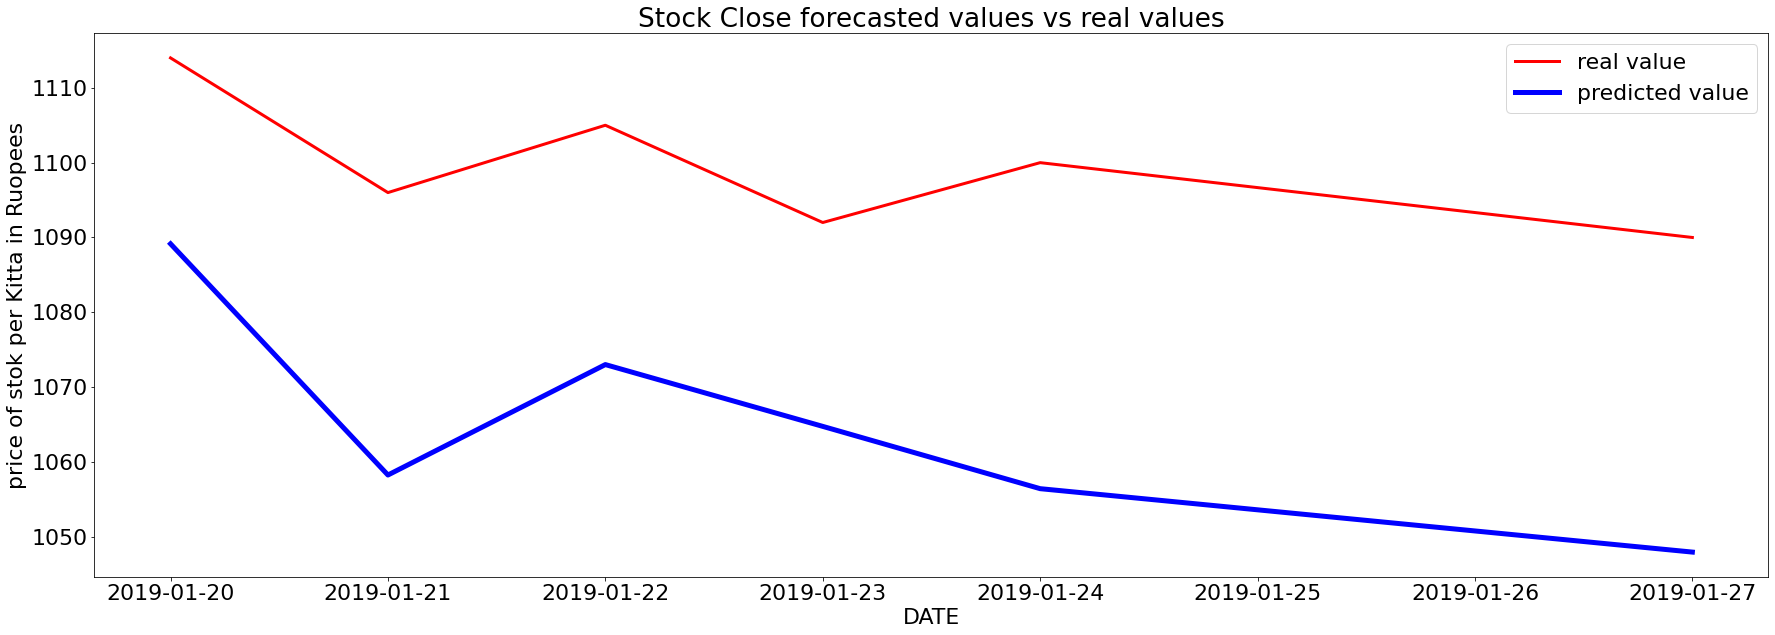

In [ ]:
real= output_test_close
predicted= model_output
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,10))
plt.plot(real, color = 'red',linewidth=3, label = 'real value')
plt.plot(predicted, color = 'blue', linewidth=5,label = 'predicted value')
plt.title('Stock Close forecasted values vs real values')
plt.xlabel('DATE')
plt.ylabel('price of stok per Kitta in Ruopees')
plt.legend()
plt.show()

In [ ]:
'''Test model 1
model = Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(5*lag, 1)))
model.add(RepeatVector(prediction_days))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(32, activation='relu')))
model.add(TimeDistributed(Dense(1)))'''

In [ ]:
'''
Test model 2
from keras.optimizers import Adam
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
batch_size = 32
opt=Adam(
    learning_rate=0.0015,
    beta_1=0.9,
    beta_2=0.99,
    epsilon=1e-05,
    amsgrad=True,
    )
model = Sequential()
#model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(lag,1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(prediction_days))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer=opt)'''

In [ ]:
'''
Test Model 3
from keras.optimizers import Adam
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
batch_size = 32
opt=Adam(
    learning_rate=0.0015,
    beta_1=0.9,
    beta_2=0.99,
    epsilon=1e-05,
    amsgrad=True,
    )
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(lag,1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(prediction_days))
model.add(LSTM(200, activation='tanh', return_sequences=True))
#model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer=opt)
'''